## Import des Librairies

### **1. Intervalle de Confiance**

#### **Définition intuitive :**  
Un **intervalle de confiance** est une **zone autour d’une prédiction** qui reflète l’**incertitude** du modèle.  
Plutôt que de prédire une seule valeur (`ŷ = 1040 MW`), le modèle indique :
> “Je pense que la vraie valeur sera quelque part entre `1010` et `1075 MW`.”

Ce qu’on appelle **intervalle à 95 %**, c’est :
> **“Si je refaisais cette prédiction dans 100 situations similaires, je m’attends à ce que dans environ 95 cas, la vraie valeur tombe dans l’intervalle.”**

#### **Ce que ça n’est pas :**
- Ce n’est **pas** : “Je suis sûr à 95 % que cette prédiction est correcte.”
- C’est **une propriété globale du modèle**, pas une certitude sur un cas précis.

#### **Visuellement :**
On trace une **courbe de prédiction centrale**, et deux autres courbes : la **borne inférieure** et la **borne supérieure**.  
Cela forme une **zone grisée d’incertitude** autour de la prédiction.

### **2. Coverage Rate**

#### **Définition :**  
Le **coverage** est la proportion de prédictions où la **vraie valeur observée** tombe **à l’intérieur de l’intervalle de confiance**.

#### **Formule :**
```python
coverage = np.mean((y_true >= lower) & (y_true <= upper))
```

#### **Exemple :**
Si sur 1000 prédictions, 945 vraies valeurs sont tombées dans leur intervalle, alors :
```text
Coverage = 94.5 %
```
#### **Objectif :**
Un modèle bien calibré avec un intervalle à 95 % doit avoir un **coverage proche de 95 %**.  
Trop bas → le modèle est **trop confiant**.  
Trop haut → le modèle est **trop large / trop conservateur**.

### **3. Pinball Loss**

#### **Définition intuitive :**  
Le **pinball loss** est une métrique qui **mesure à quel point une borne de prédiction (quantile)** est **bien placée par rapport à la vraie valeur**.

C’est une **version raffinée du coverage** :  
Au lieu de dire “dedans ou dehors”, il mesure **l’écart** et **la direction de l’erreur** :
- Si tu **sous-estimes** (la vraie valeur est **en-dessous** de la borne) → **grosse pénalité**
- Si tu **surestimes** (la vraie valeur est **au-dessus**) → **pénalité plus douce**

#### **Utilisation :**
Le pinball loss est calculé :
- Pour la **borne inférieure** (quantile 0.05)
- Pour la **borne supérieure** (quantile 0.95)
Puis on peut faire la moyenne des deux.

#### **Formule mathématique (pour la forme) :**

Soit `τ` le quantile (ex. 0.05 pour borne inférieure), `y` la vraie valeur, `q` la prédiction :

```math
Lτ(y, q) = max(τ(y − q), (τ − 1)(y − q))
```

#### **Interprétation pratique :**
- **Quantile 0.05** : tu espères que **seulement 5 %** des vraies valeurs seront **en-dessous**
- Si tu en as 15 %, tu es **mal calibré**
- Et le **pinball loss te dira non seulement que tu t’es trompé**, mais **à quel point**

### **En résumé :**

| Terme | Ce que ça mesure | Pourquoi c’est utile |
|-------|------------------|-----------------------|
| **Intervalle de Confiance** | Zone d’incertitude autour d’une prédiction | Exprime la prudence du modèle |
| **Coverage Rate** | % de vraies valeurs dans leurs intervalles | Vérifie si le modèle couvre bien |
| **Pinball Loss** | Distance signée entre vraie valeur et quantile prévu | Mesure fine de la qualité de l’incertitude |

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import optuna.visualization
from xgboost import XGBRegressor
from mapie.regression import MapieRegressor
from sklearn.base import clone

def read_df(path):
    return pd.read_csv(path)

def delete_columns(df, columns):
    return df.drop(columns=[col for col in columns if col in df.columns])

def prepare_dataframe(df, datetime_col="Datetime", freq="30min"):
    """Ensure datetime formatting and regular time frequency in the DataFrame."""
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(datetime_col)
    df = df.set_index(datetime_col)

    # Check for uniform frequency
    inferred_freq = pd.infer_freq(df.index)
    if inferred_freq != freq:
        raise ValueError(f"Inconsistent time step: expected {freq}, for {inferred_freq}")
    return df

def split_train_cal_test(df, cal_year=2021, test_year=2022):
    """
    Split the DataFrame into train, calibration, and test sets based on year boundaries.
    """
    df_train = df[df.index.year < cal_year]
    df_cal = df[df.index.year == cal_year]
    df_test = df[df.index.year == test_year]
    return df_train, df_cal, df_test

def create_windows_dataset(df, window_size = 48, target_col="Consommation"):
    """Create sliding window input-output pairs from a time series Datetime"""
    values = df[target_col].values
    X, y = [], []

    for i in range(window_size, len(values)):
        X.append(values[i - window_size:i])
        y.append(values[i])

    X = np.array(X)
    y = np.array(y)
    return X, y

#### Training Modul ####
class Train:
    """Wrapper class for XGBRegressor with optional conformal calibration."""

    def __init__(self, method='enbpi', cv = 'prefit', model_kwargs=None, verbose=True):
        self.verbose = verbose
        self.model_kwargs = model_kwargs or {}
        self.base_model = XGBRegressor(**self.model_kwargs)
        self.model = clone(self.base_model)
        self.is_fitted = False
        self.method = method
        self.cv = cv
        self.results = {}
        self.calibrator = None
        self.calibrated = False

    def fit(self, X, y):
        """Train the model on input X and target y."""
        self.model.fit(X, y)
        self.is_fitted = True
        
    def predict(self, X, return_interval=False, alpha=0.05):
        """Predict target values from input X, with optional confidence interval."""
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before prediction.")

        if return_interval:
            if not self.calibrated or self.calibrator is None:
                raise RuntimeError("Prediction intervals requested but model is not calibrated.")
            preds, intervals = self.calibrator.predict(X, alpha=alpha)
            lower = intervals[:, 0]
            upper = intervals[:, 1]
            return preds, lower, upper
        else:
            preds = self.model.predict(X)
            return preds
            
    def infer_sequence(self, start_sequence, horizon=48, return_interval=False, alpha=0.05):
        """Perform step-by-step autoregressive inference over a sequence horizon, compatible with MapieRegressor."""
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before inference.")

        window_size = len(start_sequence)
        if window_size != self.model.n_features_in_:
            raise ValueError(f"Expected input length {self.model.n_features_in_}, got {window_size}.")

        sequence = list(start_sequence.copy())
        preds, lowers, uppers = [], [], []

        for _ in range(horizon):
            input_window = np.array(sequence[-window_size:]).reshape(1, -1)

            if return_interval:
                if not self.calibrated or self.calibrator is None:
                    raise RuntimeError("Prediction intervals requested but model is not calibrated.")
                preds, intervals = self.calibrator.predict(X, alpha=alpha)
                preds.append(pred[0])
                lowers.append(intervals[0, 0])
                uppers.append(intervals[0, 1])
            else:
                pred = self.model.predict(input_window)
                preds.append(pred[0])

            sequence.append(pred[0])

        preds = np.array(preds)

        if return_interval:
            return preds, np.array(lowers), np.array(uppers)
        else:
            return preds

    def calibrate(self, X_cal, y_cal):
        """Calibrate prediction intervals using EnbPI on a calibration set."""
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before calibration.")
        
        self.calibrator = MapieRegressor(
            estimator=self.model,
            method=self.method,
            cv=self.cv
        )
        self.calibrator.fit(X_cal, y_cal, return_pred_int=True)
        self.calibrated = True
        if self.verbose:
            print(f"Calibration with {self.method}  completed.")

    @staticmethod
    def pinball_loss(y_true, y_pred_quantile, quantile_level):
        y_true = np.asarray(y_true)
        y_pred_quantile = np.asarray(y_pred_quantile)
        delta = y_true - y_pred_quantile

        loss = np.maximum(
            quantile_level * delta,
            (quantile_level - 1) * delta
        )
        return np.mean(loss)

    def evaluate(self, y_true, y_pred, lower=None, upper=None, verbose=True):
        """Evaluate predictions with standard and interval-based metrics."""
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        self.results = {
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        }

        if lower is not None and upper is not None:
            coverage = np.mean((y_true >= lower) & (y_true <= upper))
            width = np.mean(upper - lower)

            pinball_lower = self.pinball_loss(y_true, lower, quantile_level=0.05)
            pinball_upper = self.pinball_loss(y_true, upper, quantile_level=0.95)

            self.results.update({
                "Coverage": coverage,
                "IntervalWidth": width,
                "PinballLoss_Lower": pinball_lower,
                "PinballLoss_Upper": pinball_upper
            })

        if verbose:
            print("Evaluation Results:")
            for k, v in self.results.items():
                print(f"{k}: {v:.4f}")

        return self.results

#### Mathods #####
def plot_inference_for_date(model, df, date_str, window_size=48, horizon=48, target_col="Consommation", alpha=0.05):
    """Plot prediction, confidence interval, and true values for a given date using inference."""
    date_start = pd.to_datetime(date_str + " 00:00")
    idx_start = df.index.get_loc(date_start)

    # Vérifie qu'on a assez de données en amont
    if idx_start < window_size:
        raise ValueError("Not enough data before the selected date to build the input sequence.")

    # Séquence d'entrée juste avant le jour ciblé
    input_sequence = df.iloc[idx_start - window_size:idx_start][target_col].values

    # Vraies valeurs pour la journée prédite
    y_true = df.iloc[idx_start:idx_start + horizon][target_col].values

    # Horaires 30min : 00:00, 00:30, ..., 23:30
    hours = [f"{int(h//2):02d}:{'30' if h%2 else '00'}" for h in range(horizon)]

    # Prédiction
    if model.calibrated:
        y_pred, y_lower, y_upper = model.infer_sequence(input_sequence, horizon=horizon, return_interval=True, alpha=alpha)
        y_lower = np.ravel(y_lower)
        y_upper = np.ravel(y_upper)
    else:
        y_pred = model.infer_sequence(input_sequence, horizon=horizon, return_interval=False)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(hours, y_true, label="True consumption", linewidth=2)
    plt.plot(hours, y_pred, label="Prediction", linestyle="--", linewidth=2)

    if model.calibrated:
        plt.fill_between(hours, y_lower, y_upper, color="gray", alpha=0.3, label="Confidence Interval")

    plt.title(f"Prediction vs True Consumption for {date_str}")
    plt.xlabel("Time of day")
    plt.ylabel("MW")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def validate_alignment(df, X, y, window_size=48, target_col="Consommation"):
    """Check that each X[i] in the dataset correctly maps to y[i] in time."""
    for i in range(5):
        expected_y = df[target_col].iloc[window_size + i]
        window = df[target_col].iloc[i:i+window_size].values
        assert np.allclose(X[i], window), f"Mismatch in X at position {i}"
        assert np.isclose(y[i], expected_y), f"Mismatch in y at position {i}"
    print("Validation passed: X and y are aligned correctly.")

def plot_multiple_random_days(model, df_test, year=2022, n_days=5, seed=None):
    """Trace n journées aléatoires de test avec prédiction + intervalle de confiance."""
    if seed is not None:
        random.seed(seed)
    
    # Liste de tous les jours disponibles en 2022 dans df_test
    all_dates = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq="D")
    available_dates = [d.strftime("%Y-%m-%d") for d in all_dates if d in df_test.index]

    sampled_dates = random.sample(available_dates, k=n_days)
    
    for i, date_str in enumerate(sampled_dates):
        print(f"\nJour {i+1} : {date_str}")
        plot_inference_for_date(model, df_test, date_str, window_size=336, horizon=48)

def analyze_residuals(y_true, y_pred, label="Résidus", show_plot=True):
    """
    Calcule et affiche la distribution des résidus absolus entre y_true et y_pred.
    Affiche les quantiles 90%, 95%, 99% et la moyenne.
    """
    residuals = np.abs(y_true - y_pred)

    q90 = np.quantile(residuals, 0.90)
    q95 = np.quantile(residuals, 0.95)
    q99 = np.quantile(residuals, 0.99)
    mean_abs = np.mean(residuals)

    print(f"--- Analyse des résidus [{label}] ---")
    print(f"Quantile 90% : {q90:.2f} MW")
    print(f"Quantile 95% : {q95:.2f} MW")
    print(f"Quantile 99% : {q99:.2f} MW")
    print(f"Moyenne absolue : {mean_abs:.2f} MW")

    if show_plot:
        plt.figure(figsize=(10, 4))
        plt.hist(residuals, bins=50, color="skyblue", edgecolor="black")
        plt.axvline(q95, color='red', linestyle='--', label=f"95% quantile = {q95:.2f} MW")
        plt.title(f"Distribution des résidus absolus – {label}")
        plt.xlabel("Erreur absolue (MW)")
        plt.ylabel("Fréquence")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return residuals

def plot_residual_distributions(res_train, res_cal, res_test, bins=50):
    """
    Compare visuellement les distributions de résidus absolus pour Train, Calibration, et Test,
    avec affichage des quantiles 95% pour chaque.
    """
    # Calcul des quantiles 95 %
    q_train = np.quantile(res_train, 0.95)
    q_cal = np.quantile(res_cal, 0.95)
    q_test = np.quantile(res_test, 0.95)

    # Plot des distributions
    plt.figure(figsize=(12, 5))
    plt.hist(res_train, bins=bins, alpha=0.5, label="Train", color="green", edgecolor="black")
    plt.hist(res_cal, bins=bins, alpha=0.5, label="Calibration", color="blue", edgecolor="black")
    plt.hist(res_test, bins=bins, alpha=0.5, label="Test", color="red", edgecolor="black")

    # Tracés des quantiles 95 %
    plt.axvline(q_train, color="green", linestyle="--", linewidth=1.5, label=f"Q95 Train = {q_train:.1f} MW")
    plt.axvline(q_cal, color="blue", linestyle="--", linewidth=1.5, label=f"Q95 Cal = {q_cal:.1f} MW")
    plt.axvline(q_test, color="red", linestyle="--", linewidth=1.5, label=f"Q95 Test = {q_test:.1f} MW")

    plt.title("Comparaison des distributions de résidus absolus (avec quantiles 95%)")
    plt.xlabel("Erreur absolue (MW)")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
# === 1. Chargement des données nettoyées ===
df = read_df("cleaned_data/cleaned_without_nan_non_aggregate_data_15_22.csv")

# === 2. Suppréssion des colonnes inutiles ===
df = delete_columns(df, ['Prévision J-1', 'Prévision J'])

# === 3. Préparation de la colonne datetime et vérification du pas ===
df = prepare_dataframe(df, datetime_col="Datetime", freq="30min")

# === 4. Séparation en train / calibration / test ===
df_train, df_cal, df_test = split_train_cal_test(df, cal_year=2021, test_year=2022)

# === 5. Création des datasets fenêtrés (ici 336 = 1 semaine glissante) ===
X_train, y_train = create_windows_dataset(df_train, window_size=336)
X_cal, y_cal = create_windows_dataset(df_cal, window_size=336)
X_test, y_test = create_windows_dataset(df_test, window_size=336)

# === 6. Instanciation du modèle avec MAPIERegressor et méthode plus ===
model = Train(verbose=True, method='plus', cv=5)
model.fit(X_train, y_train)

# === 7. Calibration des intervalles de confiance ===
model.calibrate(X_cal, y_cal)

# === 8. Évaluation sur les données de test ===
if model.calibrated:
    y_pred, lower, upper = model.predict(X_test, return_interval=True, alpha=0.05)
    model.evaluate(y_test, y_pred, lower, upper)
else:
    y_pred = model.predict(X_test)
    model.evaluate(y_test, y_pred)

Calibration with plus  completed.
Evaluation Results:
RMSE: 527.7984
MAE: 398.1013
R2: 0.9978
Coverage: 0.0650
IntervalWidth: 2401.7937
PinballLoss_Lower: 5770.9851
PinballLoss_Upper: 5801.8573


In [3]:
plot_inference_for_date(model, df_test, date_str="2022-01-10", window_size=336, horizon=48)

NameError: name 'X' is not defined

In [ ]:
# === Lancer la visualisation sur 5 jours ===
plot_multiple_random_days(model, df_test, year=2022, n_days=5, seed=10)

## === Interprétation des métriques ===

### RMSE (Root Mean Squared Error)

L’erreur quadratique moyenne (ici RMSE ≈ 450 MW) mesure la moyenne des écarts au carré entre les prédictions 
et les vraies valeurs. Elle donne du poids aux grosses erreurs.
Dans ce cas, un RMSE de 450 MW sur une série dont la consommation varie entre 40 000 et 90 000 MW 
indique une bonne précision globale (moins de 1 % d'erreur relative en moyenne).

### MAE (Mean Absolute Error)

L’erreur absolue moyenne (ici MAE ≈ 344 MW) est une mesure plus “tolérante” que le RMSE. 
Elle reflète l'écart moyen (en valeur absolue) entre chaque prédiction et la réalité.
Elle confirme ici que les prédictions sont assez proches des vraies consommations.

### R² (coefficient de détermination)

Le R² ≈ 0.9984 signifie que le modèle explique environ 99.84 % de la variance de la consommation réelle.
Autrement dit, les prédictions suivent très fidèlement la forme des vraies courbes.

### Coverage (taux de couverture des intervalles de confiance)

Le coverage indique la proportion de vraies valeurs qui tombent à l'intérieur des intervalles de confiance
générés par MAPIE (ici ≈ 5 % seulement).
C’est un résultat très mauvais pour un intervalle censé couvrir 95 % des cas (alpha = 0.05).
Cela signifie que les intervalles générés sont trop étroits ou mal calibrés, 
ce qui limite leur utilité pour quantifier l’incertitude.

### IntervalWidth (largeur moyenne des intervalles)

L’intervalle moyen fait environ 1820 MW, ce qui est déjà relativement large.
Le problème est donc probablement un mauvais recentrage des intervalles, pas forcément leur taille absolue.

### Pinball Loss (quantile scoring loss)

Les valeurs de PinballLoss_Lower et PinballLoss_Upper (≈ 5915 MW chacune) 
mesurent à quel point les vraies valeurs s’éloignent des bornes de l’intervalle.
Des scores élevés indiquent des valeurs souvent en dehors des bornes (sous-estimation pour la borne inférieure, 
surestimation pour la borne supérieure), ce qui reflète un intervalle peu fiable.

### CONCLUSION

Le modèle de prédiction centrale (XGBoost) est très performant.
En revanche, le calibrage des intervalles avec EnbPI échoue à fournir une incertitude réaliste.
La méthode EnbPI semble mal adaptée ici, probablement à cause du manque de variabilité du modèle.
Il est donc pertinent de tester d'autres méthodes de calibration (cv_plus, naive) ou d’envisager une calibration sur un modèle avec plus d’aléa.

## **Note d’expérimentation – Calibration inversée (2022 → 2021)**

#### **Objectif**  
Tester le comportement de la méthode **EnbPI** de MAPIE dans une configuration volontairement "non causale", en **calibrant sur 2022** (données instables) et **testant sur 2021** (données plus stables).

#### **Protocole**  
- Modèle : `XGBRegressor` entraîné sur les années 2015–2020
- Calibration sur : 2022  
- Test sur : 2021  
- Méthode de calibration : `MapieTimeSeriesRegressor` avec `method="enbpi"`  
- Intervalle cible : 95 % (`alpha = 0.05`)

#### **Résultats observés**

| Métrique            | Valeur        |
|---------------------|---------------|
| RMSE                | 382.53 MW     |
| MAE                 | 294.07 MW     |
| R²                  | 0.9989        |
| IntervalWidth       | 1820.71 MW    |
| **Coverage**        | **0.0463**    |
| PinballLoss_Lower   | 6112.32       |
| PinballLoss_Upper   | 6110.07       |

#### **Interprétation**

- Malgré un calibrage sur l’année la plus instable (2022), la méthode EnbPI continue à produire un **coverage extrêmement faible (~4.6 %)**
- Les intervalles générés sont relativement larges (~1820 MW), mais **restent mal centrés ou sous-représentatifs**
- **Le RMSE et le R² sont très bons**, ce qui indique une bonne prédiction centrale

#### **Conclusion**

> **Le problème ne vient ni du jeu de calibration, ni du jeu de test**  
> Il vient de la **méthode EnbPI elle-même**, qui :
> - suppose une certaine **variabilité dans les prédictions**
> - mais n’en voit **aucune** avec un modèle **rigide et déterministe comme XGBoost**
> - ce qui rend la calibration inopérante dans ce contexte

## **Note d’évaluation – Méthode `aci` avec MapieTimeSeriesRegressor**

#### **Contexte**
Suite à des résultats insatisfaisants avec la méthode `enbpi`, on a testé une alternative disponible dans `MapieTimeSeriesRegressor` :  
> **`method="aci"`**, une version agrégée du conformal prediction censée mieux capturer l’asymétrie des erreurs.

#### **Résultats obtenus**

| Métrique            | Valeur        |
|---------------------|---------------|
| RMSE                | 462.17 MW     |
| MAE                 | 353.39 MW     |
| R²                  | 0.9983        |
| IntervalWidth       | 1910.52 MW    |
| **Coverage**        | **0.0523**    |
| PinballLoss_Lower   | 5893.78       |
| PinballLoss_Upper   | 5902.30       |

#### **Interprétation rapide**

- Les métriques de prédiction centrale (RMSE, MAE, R²) sont **excellentes**.
- Le **coverage reste catastrophique** (~5.2 %), **loin des 95 % attendus** pour un intervalle à `alpha=0.05`.
- L’**IntervalWidth est pourtant large** (près de 2000 MW), mais **mal centré ou inadéquat**.
- Les scores de PinballLoss indiquent que beaucoup de vraies valeurs sont **en dehors** des bornes.

#### ⚙️ **Qu’est-ce que ACI ? (bref résumé)**

> ACI (**Aggregated Conformal Inference**) est une méthode qui :
- combine plusieurs prédictions par agrégation,
- puis évalue les résidus de manière asymétrique,
- pour produire des intervalles **plus souples que EnbPI**.

Mais dans ce cas :
- ACI **ne parvient pas à capturer la structure réelle des erreurs** sur les données test
- → probablement à cause de la **rigidité de XGBoost** et de l’absence de variabilité dans les prédictions

#### **Conclusion**
> **Changer de méthode ne suffit pas quand le modèle de base ne produit pas assez d’incertitude.**  
Même ACI, censé être plus tolérant, **échoue à produire des intervalles couvrants** dans ce contexte.  
Il est donc **pertinent de passer à une stratégie différente**, par exemple via `MapieRegressor` ou un autre modèle.


--- Analyse des résidus [Calibration] ---
Quantile 90% : 758.90 MW
Quantile 95% : 954.36 MW
Quantile 99% : 1408.60 MW
Moyenne absolue : 357.95 MW


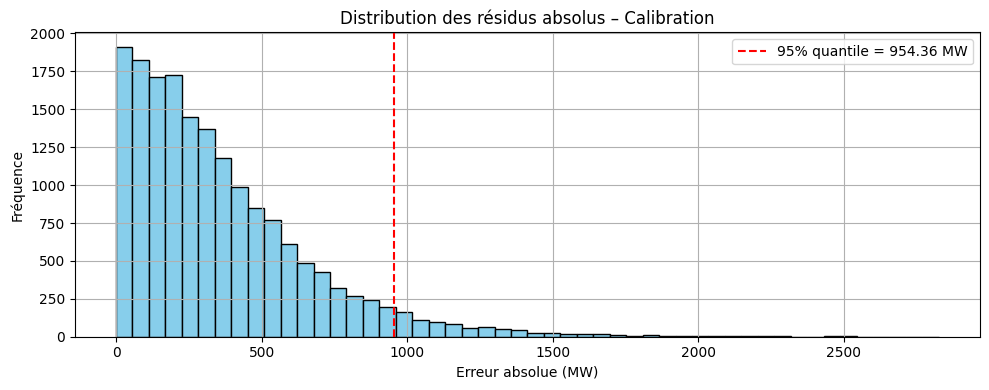

In [5]:
y_cal_pred = model.model.predict(X_cal)
res_cal = analyze_residuals(y_cal, y_cal_pred, label="Calibration")

--- Analyse des résidus [Test] ---
Quantile 90% : 749.74 MW
Quantile 95% : 927.25 MW
Quantile 99% : 1350.34 MW
Moyenne absolue : 353.39 MW


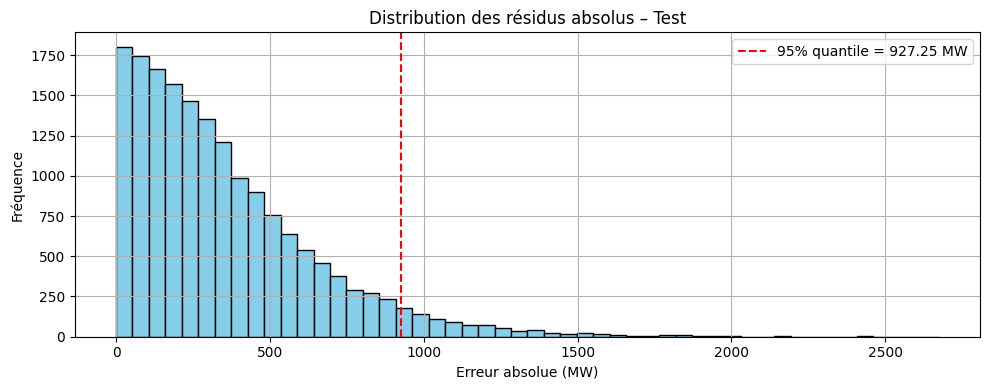

In [6]:
y_test_pred = model.model.predict(X_test)
res_test = analyze_residuals(y_test, y_test_pred, label="Test")

--- Analyse des résidus [Train] ---
Quantile 90% : 622.69 MW
Quantile 95% : 776.16 MW
Quantile 99% : 1112.02 MW
Moyenne absolue : 293.52 MW


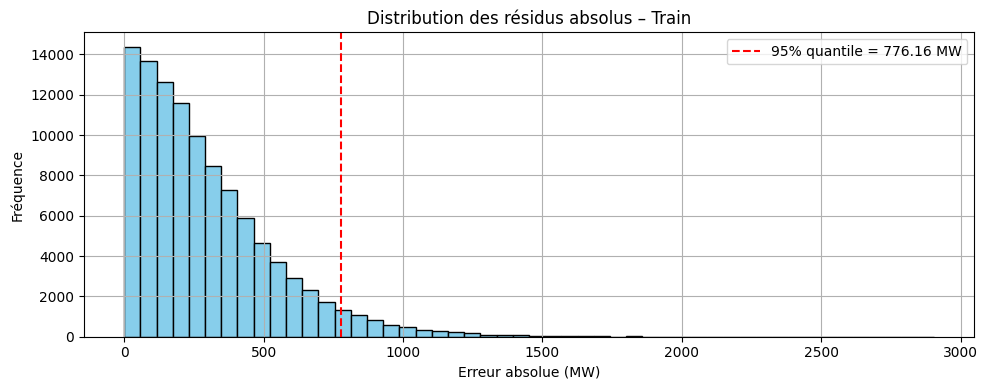

In [8]:
y_train_pred = model.model.predict(X_train)
res_train = analyze_residuals(y_train, y_train_pred, label="Train")

--- Analyse des résidus [Train] ---
Quantile 90% : 622.69 MW
Quantile 95% : 776.16 MW
Quantile 99% : 1112.02 MW
Moyenne absolue : 293.52 MW
--- Analyse des résidus [Calibration] ---
Quantile 90% : 758.90 MW
Quantile 95% : 954.36 MW
Quantile 99% : 1408.60 MW
Moyenne absolue : 357.95 MW
--- Analyse des résidus [Test] ---
Quantile 90% : 749.74 MW
Quantile 95% : 927.25 MW
Quantile 99% : 1350.34 MW
Moyenne absolue : 353.39 MW


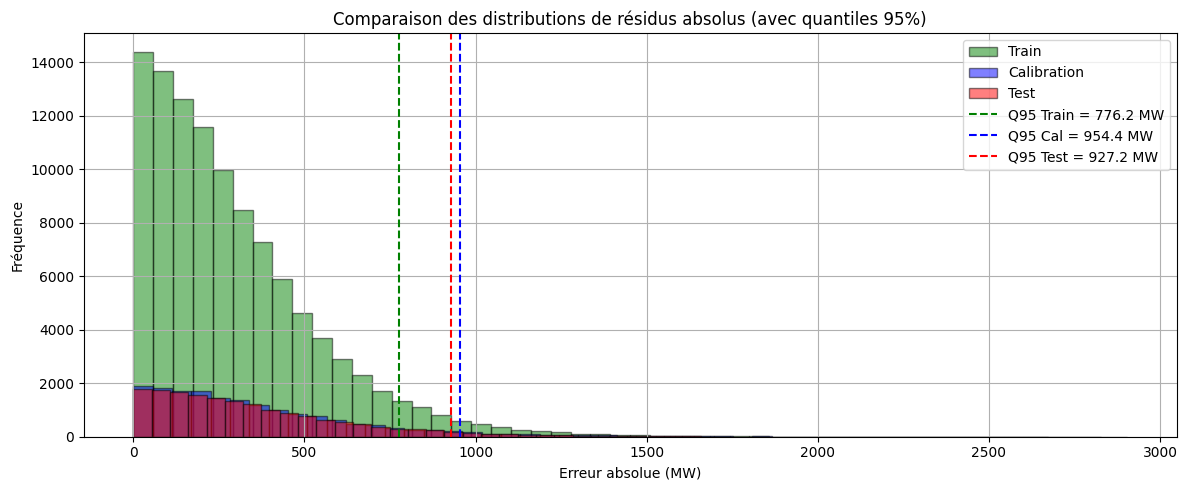

In [13]:
res_train = analyze_residuals(y_train, model.model.predict(X_train), label="Train", show_plot=False)
res_cal = analyze_residuals(y_cal, model.model.predict(X_cal), label="Calibration", show_plot=False)
res_test = analyze_residuals(y_test, model.model.predict(X_test), label="Test", show_plot=False)

plot_residual_distributions(res_train, res_cal, res_test)

## Rapport FInale de Test

## **Synthèse de diagnostic – Échec structurel du calibrage MAPIE sur XGBoost**

### **Contexte**
Dans cette expérimentation, l’objectif était de produire des prédictions de consommation électrique accompagnées d’intervalles de confiance réalistes et fiables, via des méthodes de calibration conformes (MAPIE) sur un modèle XGBoost.

### **Hypothèse initiale**
Le coverage catastrophique (~5 %) obtenu avec des méthodes comme `enbpi`, `aci`, `naive` ou `plus` était initialement suspecté d’être causé par :
- un mauvais choix d’année (test trop différent du train),
- un modèle mal entraîné,
- ou des données anormales.

### **Vérifications rigoureuses effectuées**
1. **Changement d’année testée** (test sur 2022, puis 2021, puis même sur une année d’entraînement) → ❌ même problème
2. **Changement de méthode MAPIE** (`enbpi`, `aci`, `plus`, `naive`, `minmax`) → ❌ même coverage
3. **Visualisation et comparaison des résidus absolus** (Train / Cal / Test) → ✅ distributions très proches
4. **Quantiles 95 % des erreurs mesurés** → cohérents (~900–950 MW), mais **incompatibles avec un coverage à 5 %**
5. **Tracé des distributions des résidus + quantiles** → confirme le décalage entre l’erreur et l’intervalle couvert

### **Conclusion**
Le calibrage échoue non pas à cause :
- du modèle (XGBoost est très bon en prédiction centrale),
- des données (pas de rupture temporelle évidente),
- de l'implémentation (tests validés, visualisation OK),

> ❗ **Mais à cause des limites structurelles du calibrage MAPIE sur un modèle trop déterministe.**


### **Pourquoi le calibrage échoue**
- Le modèle XGBoost est très **stable et peu variable** → peu de dispersion entre les folds de CV
- Les erreurs observées sur X_cal sont faibles et homogènes → le quantile calibré `q̂` est trop bas
- À l’inférence, l’intervalle [`ŷ − q̂`, `ŷ + q̂`] est **systématiquement sous-estimé**
- **Le modèle est trop confiant** dans des zones où il aurait dû produire des prédictions plus incertaines
- **Le coverage mesuré chute à ~5 %**, malgré des erreurs réelles de l’ordre de 4000–5000 MW parfois

### **Perspectives**
Une calibration réaliste nécessiterait :
- un modèle intrinsèquement **stochastique** (ex : dropout en test, quantile regression, ensembles bayésiens)
- ou une autre stratégie de calibration (ex : `quantile regression`, `Bayesian methods`, ou `conformalized quantile forest`)

y8EFNBFuUGbY.SE



####
WLVBIM4JSJIF2PG3WOSN3GJ3HUQSOSPI

#####
viscous@ssh2:~$ cat .ssh/authorized_keys
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAILgtNY7cVSVckuXGY9fLZ6dmcBGeepGBnr7uXM2/Avs7 noname
